In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, time, glob, pickle
from matplotlib import pyplot as plt

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

## choose runs to reduce

In [15]:
pgroup = 'p21992'

runlist = [7,8]
##############################################
from textwrap import wrap
from sfdata import SFScanInfo
jsonlist = []
for run in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))[0]
    jsonlist.append(jsonfile)
print ("will reduce {} run(s): {}".format(len(jsonlist), runlist))
jsonlist

will reduce 2 run(s): [7, 8]


['/sf/alvra/data/p21992/raw/run0007-SiN_timing_pink_12fs_002/meta/scan.json',
 '/sf/alvra/data/p21992/raw/run0008-SiN_timing_pink_12fs_001/meta/scan.json']

In [16]:
TT = TT_PSEN124

channel_delay_motor = channel_delay_beckhoff
detector_laser = channel_LaserDiode
detector_Izero = channel_Izero122

reducedir= '/sf/alvra/data/{}/work/Reduced_data/All_shots/'.format(pgroup)
saveflag = True

laser_pump, laser_unpump, Izero_pump, Izero_unpump, Delays_stage, arrTimes, Delays_corr = \
YAG_scanPP(reducedir, saveflag, jsonlist, TT, channel_delay_motor, detector_laser, detector_Izero)

/sf/alvra/data/p21992/raw/run0008-SiN_timing_pink_12fs_001/meta/scan.json
Step 101 of 101: Processing acq0101

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet            251 / 253 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude2 251 / 253 -> 1% loss ▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position2  251 / 253 -> 1% loss ▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY          251 / 253 -> 1% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET      251 / 253 -> 1% loss ▇▇▇▇▇▇▇▇▇
SLAAT-L-BECKBS:PR1_CH1_VAL_GET     250 / 253 -> 1% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 248 / 253 -> 2% loss
complete channels: 0 / 6 -> 100% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 123 pump and 123 unpump shots
----------------------------
Loaded 24992 total on/off pairs


# Load reduced runs

In [28]:
pgroup = 'p21992'
Loaddir_name = 'All_shots'

runlist = [7, 8]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
from sfdata import SFScanInfo

scan = SFScanInfo(firstrun)

data = {}
globals().update(data)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print ('{} scan(s), {} total on/off shots'.format(len(runlist), len(laser_pump)))
laser_pump   = np.asarray(laser_pump)
laser_unpump = np.asarray(laser_unpump)
Izero_pump   = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
Delays_stage = np.asarray(Delays_stage)
arrTimes     = np.asarray(arrTimes)
Delays_corr  = np.asarray(Delays_corr)

2 scan(s), 24992 total on/off shots


In [29]:
# Delay_fs = mm2fs(Delays_stage, get_timezero_NBS(firstrun))
# Delays_corr  = Delay_fs + arrTimes

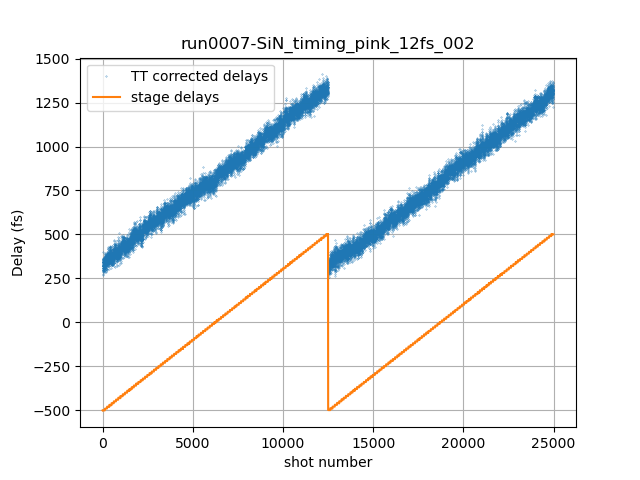

In [30]:
plt.figure()
plt.title(firstrun.split('/')[-3] )
plt.plot(Delays_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_stage, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

In [31]:
quantile = 0.5

binsize = 2
min_delay = 400
max_delay = 1300

variable_bins=False
numbins=100

pp_TT, err_pp, Delay_fs_TT = rebin_and_filter_YAG(data, binsize, min_delay, max_delay, quantile, numbins, variable_bins)

6664 shots out of 22434 survived (total shots: 24992)


In [32]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

#fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

In [33]:
from lmfit.models import PseudoVoigtModel

index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

## Fit the curve with function chosen before
fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
fit.p0 = better_p0(fit.p0, 4, 200)# overwrite some values (index) if needed: 
#fit.p0 =[-80, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[-80, 0.16, 100, 0.0, 200]
fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting


## Gaussian fit of the derivative
pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [800, 0, 20, 0])

## Pseudo Voigt fit of the derivative
mod = PseudoVoigtModel()
pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=0.0005, center= 900, sigma=0.4, fraction=0.5, x=Delay_fs_TT)

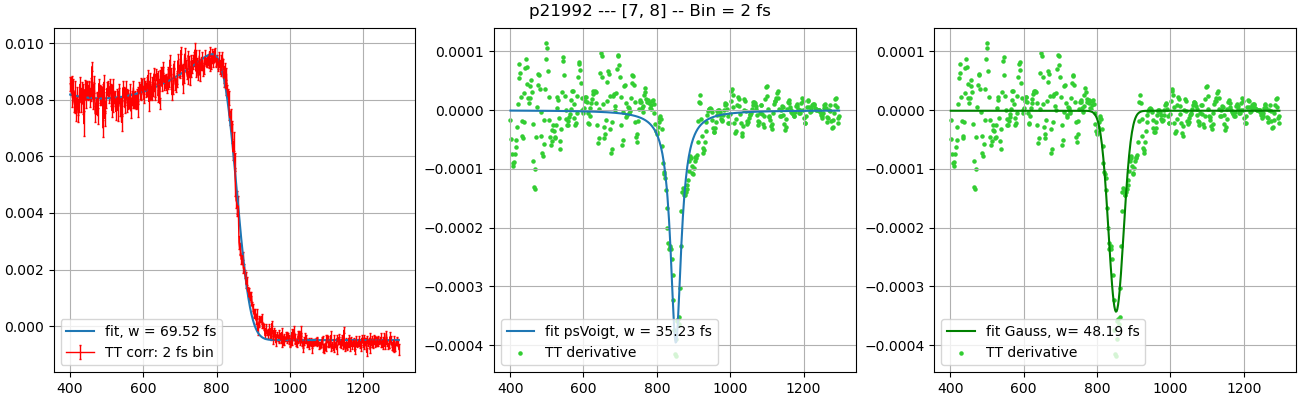

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4), constrained_layout=True)
fig.suptitle(titlestring_stack + ' -- Bin = {} fs'.format(binsize))
ax1.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corr: {} fs bin'.format(binsize))
ax1.plot(Delay_fs_TT, pp_fit, label = 'fit, w = {:.2f} fs'.format(fit.popt[2]))
ax1.legend(loc='lower left')
ax1.grid()

ax2.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT derivative', s = 5)
ax2.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit psVoigt, w = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
ax2.grid()
ax2.legend(loc='lower left')

ax3.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT derivative', s = 5)
ax3.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'fit Gauss, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

ax3.grid()
ax3.legend(loc='lower left')